In [176]:
%matplotlib inline
import os
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set(style="darkgrid")

BASE_PATH = '../'
ROWS_PATH = f'{BASE_PATH}/rows/2024-04-04_rows.json'
DATASET_PATH = f'{BASE_PATH}/datasets'

MAX_ANSWERS = 4
FIG_SIZE = (10, 5)

rows = json.load(open(ROWS_PATH, 'r'))
rows_df = pd.DataFrame(rows)
question_rows = []
all_annotations = []
removed_h = 0
total = 0

for row in rows:
    h_tag_lines = []
    no_h_path = f'../data/integreat_pages/{row["city"]}/{row["language"]}/pages_no_h/{row["pageId"]}.txt'
    no_h_file = open(no_h_path, 'r')
    no_h_context = no_h_file.read().split('\n')
    context = row['context']
    
    for i, line in enumerate(context.split('\n')):
        no_h_index = i - len(h_tag_lines)
        if no_h_index >= len(no_h_context) or line.strip() != no_h_context[no_h_index].strip():
            # if no_h_index < len(no_h_context):
            #     print(i, f'"{line}"', f'"{no_h_context[i - len(h_tag_lines)]}"')
            h_tag_lines.append(i)
                
    for question in row['questions']:
        question_row = row.copy()
        annotations = [annotation for annotation in question['annotations'] if
                       not annotation['skipped'] and not annotation['archived']]
        question_row['question'] = question['question']
        question_row['id'] = question['id']

        for index, annotation in enumerate(annotations):
            annotation_row = {
                **annotation,
                'selected': len(annotation['answerLines']),
                'context': context,
                'answerCount': len(context.split('\n')) - 1
            }
            all_annotations.append(annotation_row)
            
            removed_h += len(annotation['answerLines']) - len([x for x in annotation['answerLines'] if x not in h_tag_lines])
            total += len(annotation['answerLines'])
            question_row[f'answers{index}'] = annotation['answerLines']
            question_row[f'noAnswer{index}'] = annotation['noAnswer']
            question_row[f'user{index}'] = annotation['user']

        question_rows.append(question_row)

questions_df = pd.DataFrame(question_rows,
                            columns=['id', 'question', 'answers0', 'answers1', 'noAnswer0', 'noAnswer1', 'user0', 'user1', 'context', 'city',
                                     'language', 'pageId'])
annotations_df = pd.DataFrame(all_annotations)
print('Removed:', removed_h, total)
print('Annotation count:', len(all_annotations))

# Agreement for all answers
selected_answers = annotations_df.selected.sum()
total_answers = annotations_df.answerCount.sum()
selected_percentage = selected_answers / total_answers
p_selected_agreement = pow(selected_percentage, 2)

# Agreement for max 4 answers
selected_answers_filtered = annotations_df[annotations_df.selected <= MAX_ANSWERS].selected.sum()
total_answers_filtered = annotations_df[annotations_df.selected <= MAX_ANSWERS].answerCount.sum()
selected_percentage_filtered = selected_answers_filtered / total_answers_filtered
p_selected_agreement_filtered = pow(selected_percentage_filtered, 2)

print('Selected agreement/percentage all:', p_selected_agreement, selected_percentage)
print('Selected agreement/percentage (max 4 answers):', p_selected_agreement_filtered, selected_percentage_filtered)

Removed: 1693 19004
Annotation count: 3688
Selected agreement/percentage all: 0.03444146750955702 0.18558412515502778
Selected agreement/percentage (max 4 answers): 0.0031251760472214953 0.055903274029536903


51


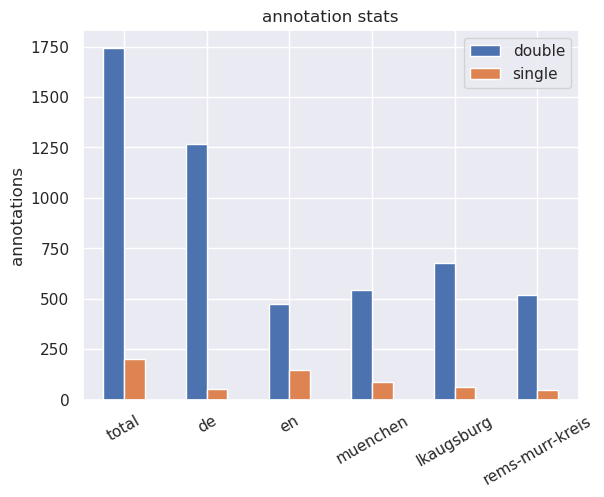

In [158]:
# Annotations stats
def plot_grouped(axis, df, title, y_label, x_ticks, y_ticks=None, x_label=''):
    df.plot.bar(ax=axis, rot=30)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.set_xticklabels(x_ticks)
    if y_ticks is not None:
        axis.set_yticks(y_ticks)


def plot_annotation_stats(dfs, x_ticks):
    _, axis = plt.subplots()
    annotation_stats_df = pd.DataFrame([[df.answers1.count(), df.answers0.count() - df.answers1.count()] for df in dfs],
                                       columns=['double', 'single'])
    plot_grouped(axis, annotation_stats_df, 'annotation stats', 'annotations', x_ticks)
    
print(questions_df[questions_df['language'] == 'de'].answers0.count() - questions_df[questions_df['language'] == 'de'].answers1.count())

plot_annotation_stats(
    [questions_df, questions_df[questions_df['language'] == 'de'], questions_df[questions_df['language'] == 'en'],
     questions_df[questions_df['city'] == 'muenchen'], questions_df[questions_df['city'] == 'lkaugsburg'],
     questions_df[questions_df['city'] == 'rems-murr-kreis']],
    ['total', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr-kreis'])

Mean document length (chars): 1648.37
Median document length (chars): 1371.0
Mean document length (sentences): 26.8
Median document length (sentences): 22.0


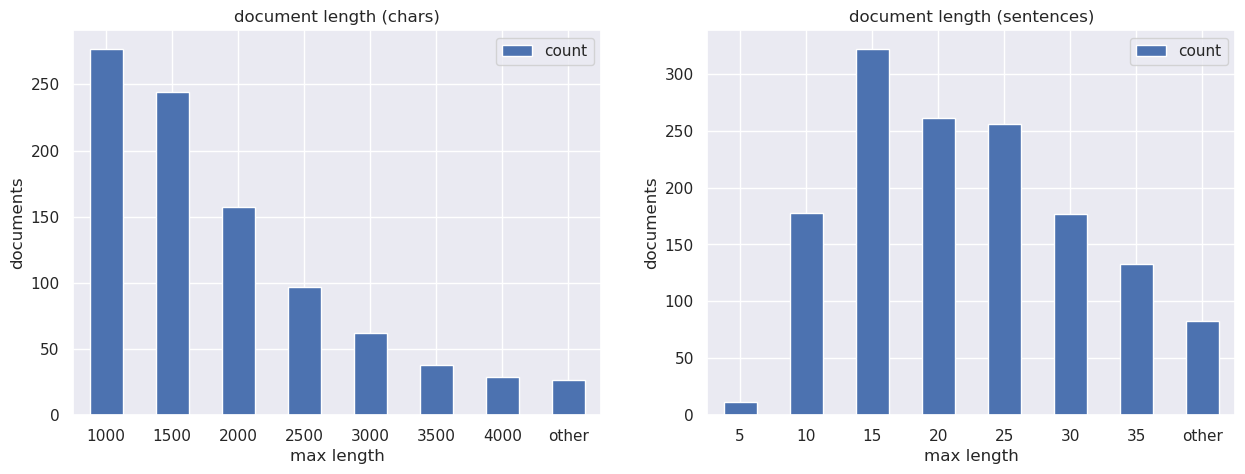

In [159]:
# Document length stats
documents_df = pd.DataFrame(rows)


def plot_counts(axis, column, title, x_label, y_label, digits=0, x_label_rot=0):
    value_count_df = column.value_counts().reset_index()
    value_count_df.columns = ['value', 'count']
    value_count_df = value_count_df.sort_values('value')

    value_count_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(value) if digits == 0 else round(value, ndigits = digits)}' for value in value_count_df['value']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Mean {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {round(column.median(), 2)}')
    
    
def get_bins(column, bins):
    bins_df = pd.cut(column, bins=bins, include_lowest=True).value_counts().reset_index()
    bins_df.columns = ['bin', 'count']
    bins_df['sort'] = bins_df.bin.map(lambda x: x.left)
    bins_df = bins_df.sort_values('sort')
    return bins_df


def plot_count_bins(axis, column, bins, title, x_label, y_label, digits=0, x_label_rot=0, other=True):
    bins_df = get_bins(column, bins)

    bins_df.plot.bar(ax=axis, rot=x_label_rot, color='b')
    axis.set_xticklabels([f'{int(bin.right) if digits == 0 else round(bin.right, ndigits = digits)}' if bin.right != bins[-1] or not other else 'other' for bin in bins_df['bin']])
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)

    print(f'Mean {title}: {round(column.mean(), 2)}')
    print(f'Median {title}: {round(column.median(), 2)}')


group_by_context_length = rows_df.context.str.len().value_counts().reset_index()
group_by_context_length.columns = ['document_length', 'document']

tmp = rows_df.copy()
group_by_answer_count = rows_df.copy()
group_by_answer_count['document_length'] = tmp.apply(lambda x: len(x.context.split('\n')) - 1, axis=1)
group_by_answer_count = group_by_answer_count.reset_index()

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))
plot_count_bins(ax0, group_by_context_length.document_length,
                numpy.array([0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 10000]), 'document length (chars)',
                'max length', 'documents')
plot_count_bins(ax1, group_by_answer_count.document_length, numpy.array([0, 5, 10, 15, 20, 25, 30, 35, 40]),
                'document length (sentences)', 'max length', 'documents')

In [160]:
# Prepare questions with two annotations
def prepare_jaccard(df):
    df['intersection'] = df.apply(lambda x: list(set(x.answers0).intersection(set(x.answers1))), axis=1)
    df['answers'] = df.apply(lambda x: sorted(list(set(x.answers0).intersection(set(x.answers1)))), axis=1)
    df['union'] = df.apply(lambda x: list(set(x.answers0).union(set(x.answers1))), axis=1)
    df['jaccard_pure'] = df.apply(lambda x: len(x.intersection) / len(x.union) if len(x.union) > 0 else 1, axis=1)
    df['jaccard_cc'] = df.apply(lambda x: (x.jaccard_pure - p_selected_agreement) / (1 - p_selected_agreement), axis=1)
    df['jaccard'] = df['jaccard_pure']
    df['jaccard_cc_filtered'] = df.apply(lambda x: (x.jaccard_pure - p_selected_agreement_filtered) / (1 - p_selected_agreement_filtered), axis=1)
    df['diff0'] = df.apply(lambda x: list(set(x.answers0).difference(x.answers1)), axis=1)
    df['diff1'] = df.apply(lambda x: list(set(x.answers1).difference(x.answers0)), axis=1)
    return df
    
double_annotations_df = prepare_jaccard(questions_df[~questions_df.answers0.isnull() & ~questions_df.answers1.isnull()].copy())
filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() <= MAX_ANSWERS) & (double_annotations_df.answers1.str.len() <= MAX_ANSWERS)]
inverse_filtered_double_annotations_df = double_annotations_df[(double_annotations_df.answers0.str.len() > MAX_ANSWERS) | (double_annotations_df.answers1.str.len() > MAX_ANSWERS)]

In [161]:
# h tags


In [162]:
# Plotting helpers
def print_row(values, width=10):
    print(' | '.join([f'{it:^{width}}' for it in values]))


def print_absolute_percentage_row(values, divisor, width=10):
    print_row(values[:1] + [f'{value} ({int(value / divisor * 100)}%)' for value in values[1:]], width)

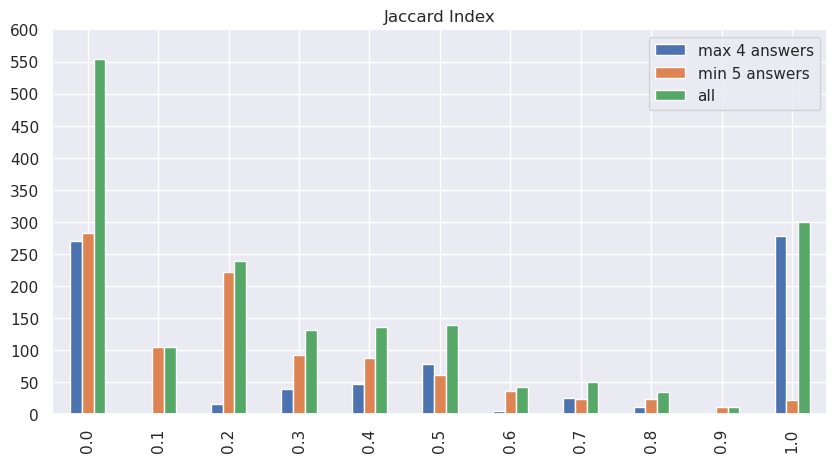

In [163]:
# Plot intersection over union / Jaccard-Index
jaccard_bins = numpy.arange(-0.1, 1.01, 0.1)
# _, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
# plot_count_bins(ax0, filtered_double_annotations_df.jaccard, jaccard_bins, f'jaccard index (max {MAX_ANSWERS} answers)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)
# plot_count_bins(ax1, inverse_filtered_double_annotations_df.jaccard, jaccard_bins, f'jaccard index (min {MAX_ANSWERS + 1} answers)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)
# plot_count_bins(ax2, double_annotations_df.jaccard, jaccard_bins, 'jaccard index (all)', 'jaccard', 'documents', digits=2, x_label_rot=45, other=False)

_, ax = plt.subplots(figsize=(10,5))
answer_dfs = [filtered_double_annotations_df, inverse_filtered_double_annotations_df, double_annotations_df]
jaccard_answer_df = pd.DataFrame([get_bins(df.jaccard, jaccard_bins).reset_index()['count'] for df in answer_dfs]).transpose()
jaccard_answer_df.plot(ax=ax, kind='bar', stacked=False, title='Jaccard Index')
ax.legend([f'max {MAX_ANSWERS} answers', f'min {MAX_ANSWERS + 1} answers', 'all'])
ax.set_xticklabels([round(bin, 1) for bin in jaccard_bins[1:]])
ax.set_yticks(numpy.arange(0, 650, 50))
print()

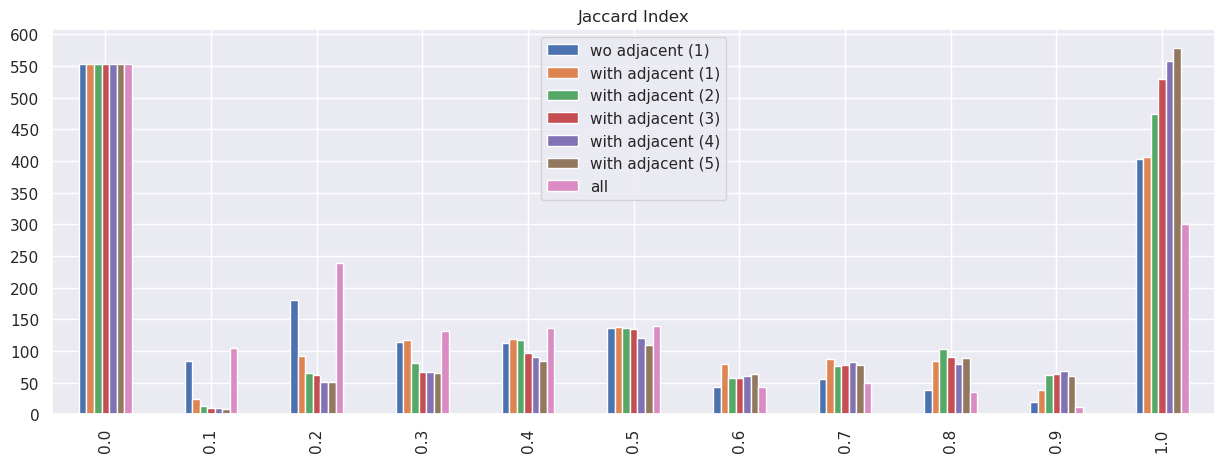

In [164]:
# Remove or add adjacent
def prepare_adjacent_df(df, transfer):
    df = df.copy()
    tmp = df.copy()
    df['old0'] = df['answers0']
    df['old1'] = df['answers1']
    df['answers0'] = tmp.apply(lambda row: transfer(row.answers0, row.answers1), axis=1)
    df['answers1'] = tmp.apply(lambda row: transfer(row.answers1, row.answers0), axis=1)
    return prepare_jaccard(df)

adjacent = lambda line, answers, others: line not in others and ((line - 1 in answers and line - 1 in others) or (line + 1 in answers and line + 1 in others))

# Without context, adjacent answers are removed
remove_directly_adjacent = lambda answers0, answers1: [line for line in answers0 if not adjacent(line, answers0, answers1)]
remove_adjacent = lambda answers0, answers1: [line for line in answers0 if not adjacent(line, answers0, answers1)]
wo_adjacent_1_df = prepare_adjacent_df(double_annotations_df.copy(), remove_directly_adjacent)
wo_adjacent_2_df = prepare_adjacent_df(wo_adjacent_1_df, remove_directly_adjacent)

# With context, adjacent answers are added
add_adjacent = lambda answers0, answers1: list(set(set(answers0).union([line for line in answers1 if adjacent(line, answers1, answers0)])))
w_adjacent_1_df = prepare_adjacent_df(double_annotations_df, add_adjacent)
w_adjacent_2_df = prepare_adjacent_df(w_adjacent_1_df, add_adjacent)
w_adjacent_3_df = prepare_adjacent_df(w_adjacent_2_df, add_adjacent)
w_adjacent_4_df = prepare_adjacent_df(w_adjacent_3_df, add_adjacent)
w_adjacent_5_df = prepare_adjacent_df(w_adjacent_4_df, add_adjacent)

_, ax = plt.subplots(figsize=(15,5))
adjacent_dfs = [wo_adjacent_1_df, w_adjacent_1_df, w_adjacent_2_df, w_adjacent_3_df, w_adjacent_4_df, w_adjacent_5_df, double_annotations_df]
jaccard_adjacent_df = pd.DataFrame([get_bins(df.jaccard, jaccard_bins).reset_index()['count'] for df in adjacent_dfs]).transpose()
jaccard_adjacent_df.plot(ax=ax, kind='bar', stacked=False, title='Jaccard Index')
ax.legend(['wo adjacent (1)', 'with adjacent (1)', 'with adjacent (2)', 'with adjacent (3)', 'with adjacent (4)', 'with adjacent (5)', 'all'])
ax.set_xticklabels([round(bin, 1) for bin in jaccard_bins[1:]])
ax.set_yticks(numpy.arange(0, 650, 50))
print()

In [180]:
# Dataset
DATASET_COLUMNS = ['id', 'question', 'answers', 'context', 'city', 'language', 'jaccard']
JACCARD_THRESHOlD = 0.5
jaccard_df = w_adjacent_3_df
jaccard_agreement_df = jaccard_df[jaccard_df.jaccard >= JACCARD_THRESHOlD]

divided = 0
no_answer = 0

for _, row in jaccard_agreement_df.iterrows():
    answers = row.answers
    if len(answers) > 0 and len(answers) != len(range(answers[0], answers[-1] + 1)):
        divided += 1
    if len(answers) == 0:
        no_answer += 1


def print_w_percentage(value, reference_df = jaccard_agreement_df):
    return f'{value}({int(value / len(reference_df) * 100)}%)'


print(f'Count: {print_w_percentage(len(jaccard_agreement_df), jaccard_df)}')
print(f'Divided answers: {print_w_percentage(divided)} | Connected answers: {print_w_percentage(len(jaccard_agreement_df) - divided)}')
print(f'No answer: {print_w_percentage(no_answer)}')
print(f'Mean jaccard: {round(jaccard_agreement_df.jaccard.mean(), 2)}')
print(f'Median jaccard: {round(jaccard_agreement_df.jaccard.median(), 2)}')


def write_dataset(df, suffix=''):
    df = pd.DataFrame(df, columns=DATASET_COLUMNS)
    df_file = open(f'{DATASET_PATH}_dataset{suffix}.json', 'w')
    df_file.write(df.to_json(orient='records'))
    df_file = open(f'{DATASET_PATH}_dataset{suffix}.jsonl', 'w')
    df_file.write(df.to_json(lines=True, orient='records'))
    return df
    

dataset_df = write_dataset(jaccard_agreement_df)
# dataset_de_df = write_dataset(jaccard_agreement_df[jaccard_agreement_df['language'] == 'de'], '_de')
# dataset_en_df = write_dataset(jaccard_agreement_df[jaccard_agreement_df['language'] == 'en'], '_en') 

print(jaccard_agreement_df.value_counts(jaccard_agreement_df.question).count())

dataset_df

Count: 906(51%)
Divided answers: 151(16%) | Connected answers: 755(83%)
No answer: 165(18%)
Mean jaccard: 0.86
Median jaccard: 1.0
894


,id,question,answers,context,city,language,jaccard
1,2,Was versteht man unter Selbsthilfe?,"[4, 5, 6, 7, 8]",Selbsthilfezentrum\nSelbsthilfezentrum\nDas Se...,muenchen,de,0.833333
4,6,Wo kann man Tickets für die Aufführungen der M...,"[18, 19, 20]",Münchner Kammerspiele\nMünchner Kammerspiele\n...,muenchen,de,1.000000
5,4,Wie heißt das Theater der Stadt München?,"[1, 2]",Münchner Kammerspiele\nMünchner Kammerspiele\n...,muenchen,de,1.000000
7,9,Welche Art von Zertifikat wird für eine Nieder...,"[27, 28, 29, 31, 32, 33]",Brauche ich ein Zertifikat?\nBrauche ich ein Z...,muenchen,de,1.000000
11,12,"An wen sollten sich Selbständige wenden, um ei...","[2, 3, 4, 5, 6, 7, 8]",Bürgerinnen und Bürger aus EU und EWR\nBürgeri...,muenchen,de,0.875000
...,...,...,...,...,...,...,...
4839,4832,What kind of support is available for children...,[9],For children and adolescents\nBetreuung und In...,muenchen,en,1.000000
4863,4860,How can I ensure my child's safety in school?,[],Protecting children and adolescents\nProtectin...,muenchen,en,1.000000
4893,4890,How can I contact a private tutor for language...,"[1, 2, 3, 4]",Private tutoring - General information\nPrivat...,muenchen,en,0.800000
4896,4892,Which public schools offer German language cla...,[],Grundschule (primary school)\nGrundschule\nReg...,muenchen,en,1.000000


In [166]:
# Expanded answers
expanded_answers_df = dataset_df[(jaccard_agreement_df.old0 != jaccard_agreement_df.answers0) | (jaccard_agreement_df.old1 != jaccard_agreement_df.answers1)]

for _, question in expanded_answers_df.iterrows():
    print(question.question)
    

An wen sollten sich Selbständige wenden, um eine Arbeitserlaubnis zu erhalten?
Kann man mit einer Aufenthaltserlaubnis zum vorübergehenden Schutz in Deutschland arbeiten?
Welchen Personengruppen ist eine Arbeitsaufnahme nicht erlaubt?
Welche Aktivitäten können im Offenen Haus unternommen werden?
Wie nennt man "irreguläre Beschäftigung" umgangssprachlich?
Was ist notwendig, um eine (duale) betriebliche Ausbildung zu machen?
Gibt es im Café Bellevue barrierefreien Zugang?
Welche Art von Angeboten richtet sich an Frauen im Café Glanz für Frauen?
Wer sorgt dafür, dass Kinder regelmäßig die Schule besuchen?
Ab welchem Alter müssen Kinder in Deutschland zur Schule gehen?
Wie lange dauert die Berufsschulpflicht in Bayern?
Was finden Frauen und ihre Kinder in den Frauenhäusern?
Wie kann man mit den Frauenhäusern in Kontakt treten?
Welche Rechte haben Eltern bei der Erziehung ihrer Kinder?
Was geschieht, wenn ein Asylbewerber oder eine Person mit Duldungsstatus krank wird und einen Krankenschei

In [167]:
# Many answers
many_answers_df = dataset_df[(dataset_df.answers.str.len() > MAX_ANSWERS)]
many_answers_df

,id,question,answers,context,city,language,jaccard
1,2,Was versteht man unter Selbsthilfe?,"[4, 5, 6, 7, 8]",Selbsthilfezentrum\nSelbsthilfezentrum\nDas Se...,muenchen,de,0.833333
7,9,Welche Art von Zertifikat wird für eine Nieder...,"[27, 28, 29, 31, 32, 33]",Brauche ich ein Zertifikat?\nBrauche ich ein Z...,muenchen,de,1.000000
11,12,"An wen sollten sich Selbständige wenden, um ei...","[2, 3, 4, 5, 6, 7, 8]",Bürgerinnen und Bürger aus EU und EWR\nBürgeri...,muenchen,de,0.875000
14,80,Welche Angaben sind in der Gehaltsabrechnung o...,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]",Gehaltsabrechnung\nGehaltsabrechnung\nWenn Sie...,muenchen,de,1.000000
26,21,Welchen Personengruppen ist eine Arbeitsaufnah...,"[2, 3, 4, 5, 6, 7]",Drittstaatenangehörige\nDrittstaatenangehörige...,muenchen,de,1.000000
...,...,...,...,...,...,...,...
4703,4691,Where can I find support groups for addiction ...,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",Blaues Kreuz München e. V. - Help for addicts\...,muenchen,en,1.000000
4779,4774,Who can I contact for help with housing-relate...,"[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13]",Help if you are in danger of losing your home\...,muenchen,en,0.846154
4804,4803,Who can help me if I face issues at work?,"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",Fair Integration Advice Centre\nFair integrati...,muenchen,en,0.928571
4827,4821,How can I report bullying in school?,"[1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...",JIZ - Counselling for school stress and/or bul...,muenchen,en,0.894737


Mean Jaccard Index by User: 0.34
Median Jaccard Index by User: 0.34


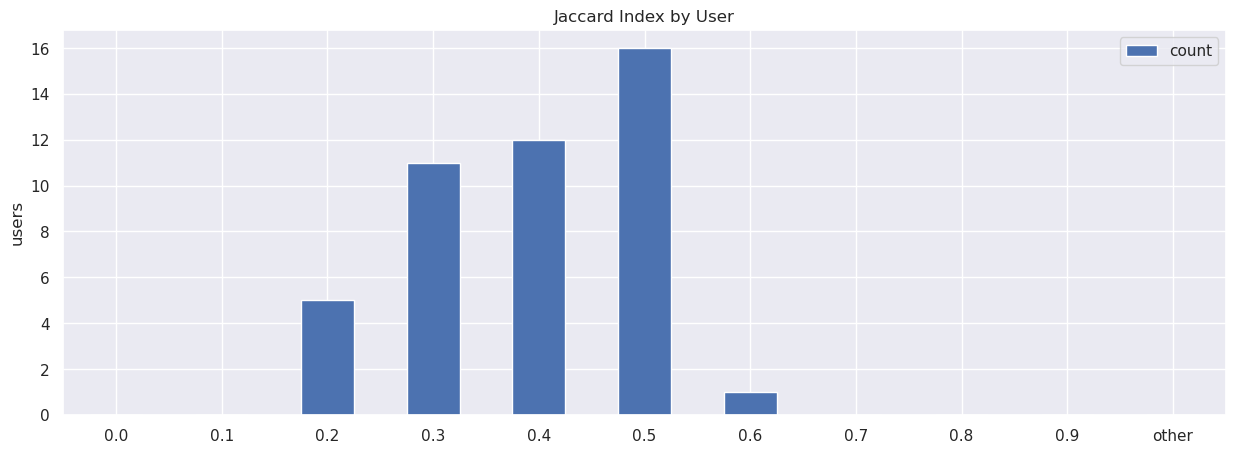

In [168]:
# Agreement by user
tmp = double_annotations_df
columns = list(tmp.columns)
a, b = columns.index('user0'), columns.index('user1')
columns[b], columns[a] = columns[a], columns[b]
tmp = tmp[columns]

agreement_by_user_df = pd.concat([double_annotations_df, tmp]).groupby(['user0']).filter(lambda group: len(group) > 20).groupby(['user0']).jaccard
mean_agreement_by_user_df = pd.DataFrame(agreement_by_user_df.mean())

_, ax = plt.subplots(figsize=(15,5))
plot_count_bins(ax, mean_agreement_by_user_df.jaccard, jaccard_bins, 'Jaccard Index by User', '', 'users', digits=1)

In [169]:
# Agreement by city and language
by_city_language_dfs = [
    double_annotations_df, 
    double_annotations_df[double_annotations_df['language'] == 'de'], 
    double_annotations_df[double_annotations_df['language'] == 'en'],
    double_annotations_df[double_annotations_df['city'] == 'muenchen'],
    double_annotations_df[double_annotations_df['city'] == 'lkaugsburg'],
    double_annotations_df[double_annotations_df['city'] == 'rems-murr-kreis']
]

rows = ['all', 'de', 'en', 'muenchen', 'lkaugsburg', 'rems-murr']
agreement_by_city_language = [[df.jaccard.mean(), df.jaccard.median()] for df in by_city_language_dfs]
print_row(['', 'mean', 'median'])
for index, row in enumerate(agreement_by_city_language):
    print_row([rows[index], round(row[0], 2), round(row[1], 2)])

           |    mean    |   median  
   all     |    0.34    |    0.2    
    de     |    0.34    |    0.2    
    en     |    0.32    |    0.2    
 muenchen  |    0.37    |    0.25   
lkaugsburg |    0.32    |    0.17   
rems-murr  |    0.32    |    0.17   


 answers   | agreement  | one-sided  |  overlap   | no agreement
   < 2     | 265 (53%)  |  56 (11%)  |   9 (1%)   | 163 (33%) 
   < 3     | 273 (43%)  | 109 (17%)  |  33 (5%)   | 219 (34%) 
   < 4     | 278 (35%)  | 162 (20%)  |  63 (8%)   | 271 (35%) 
   < 5     | 284 (31%)  | 198 (21%)  | 105 (11%)  | 324 (35%) 
   < 7     | 291 (25%)  | 274 (24%)  | 164 (14%)  | 397 (35%) 
   < 10    | 294 (21%)  | 338 (25%)  | 250 (18%)  | 463 (34%) 
   all     | 297 (17%)  | 518 (29%)  | 375 (21%)  | 554 (31%) 


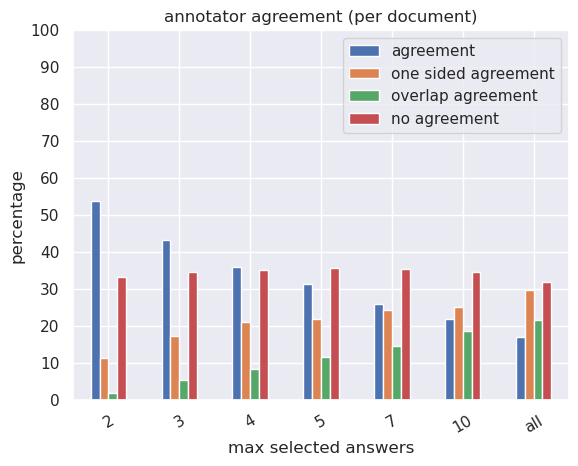

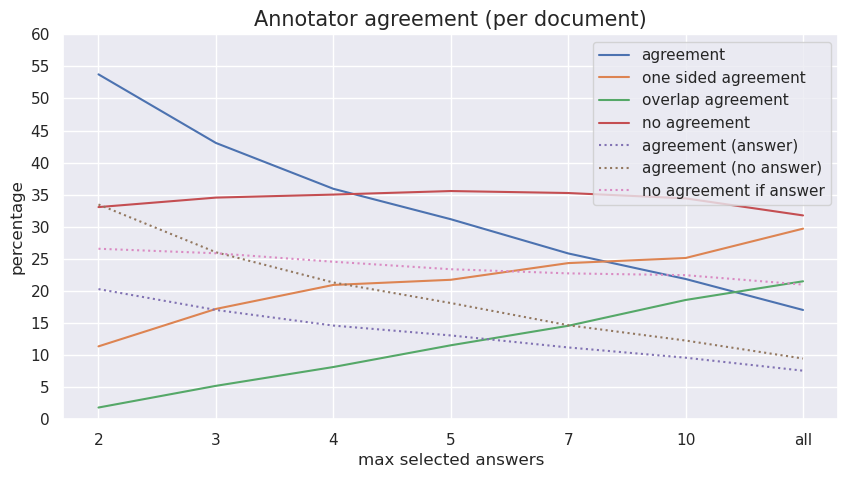

In [170]:
max_answers_thresholds = [2, 3, 4, 5, 7, 10]
agreement_options = ['answers', 'agreement', 'one-sided', 'overlap', 'no agreement']
columns = ['agreement', 'one sided agreement', 'overlap agreement', 'no agreement', 'agreement (answer)',
           'agreement (no answer)', 'no agreement if answer']


def get_annotator_agreement(df, name):
    total_count = len(df)
    raw_agreement = len(df[(df.diff0.str.len() == 0) & (df.diff1.str.len() == 0)])
    raw_agreement_one_sided = len(
        df[((df.diff0.str.len() == 0) != (df.diff1.str.len() == 0)) & (df.intersection.str.len() > 0)])
    raw_agreement_overlap = len(
        df[(df.diff0.str.len() > 0) & (df.diff1.str.len() > 0) & (df.intersection.str.len() > 0)])
    raw_no_agreement = len(
        df[((df.answers0.str.len() > 0) | (df.answers1.str.len() > 0)) & (df.intersection.str.len() == 0)])
    raw_agreement_no_answer = len(df[(df.answers0.str.len() == 0) & (df.answers1.str.len() == 0)])
    raw_agreement_answer = raw_agreement - raw_agreement_no_answer
    raw_no_agreement_answer = len(df[(df.answers0.str.len() == 0) != (df.answers1.str.len() == 0)])

    print_absolute_percentage_row(
        [name, raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement], total_count)
    raw = [raw_agreement, raw_agreement_one_sided, raw_agreement_overlap, raw_no_agreement, raw_agreement_answer,
           raw_agreement_no_answer, raw_no_agreement_answer]

    return [it / total_count * 100 for it in raw]


def get_double_annotations_max_answers(df, max_answers):
    return df[(df.answers0.str.len() <= max_answers) & (df.answers1.str.len() <= max_answers)]


def get_max_answers_agreement(df):
    agreements = []
    print_row(agreement_options)
    for max_answers in max_answers_thresholds:
        agreements.append(get_annotator_agreement(get_double_annotations_max_answers(df, max_answers),
                                                  f'< {max_answers}{"" if len(str(max_answers)) == 2 else " "}'))
    agreements.append(get_annotator_agreement(df, 'all '))

    return pd.DataFrame(agreements)


x_ticks = max_answers_thresholds + ['all']
y_ticks = numpy.arange(0, 110, 10)
max_answers_agreement_df = get_max_answers_agreement(double_annotations_df)
max_answers_agreement_df.columns = columns
_, ax = plt.subplots()
plot_grouped(ax, max_answers_agreement_df.copy().iloc[:, :4], title='annotator agreement (per document)',
             x_label='max selected answers', y_label='percentage', x_ticks=x_ticks, y_ticks=y_ticks)

_, ax = plt.subplots(figsize=FIG_SIZE)
ax.set_title('Annotator agreement (per document)', fontsize=15)
ax.set_xlabel('max selected answers')
ax.set_ylabel('percentage')

for index in range(len(max_answers_agreement_df.columns)):
    max_answers_agreement_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 4 else ':')

ax.legend(columns)
ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
ax.set_xticklabels(x_ticks)
ax.set_yticks(numpy.arange(0, 65, 5))
ax.set_ylim(0)
plt.show()

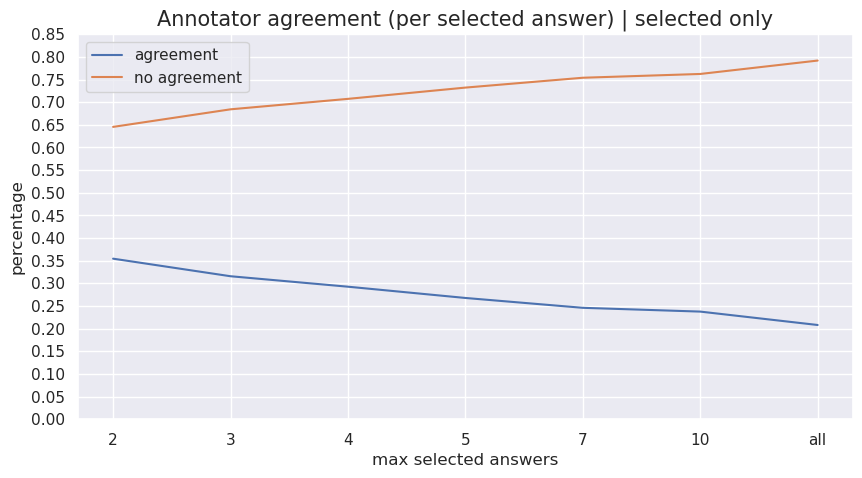

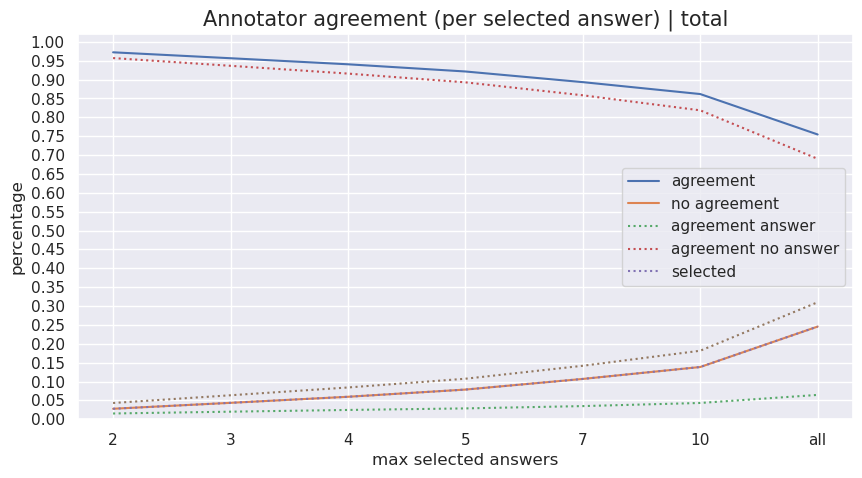

In [171]:
# Plot annotator agreement (per answer)
def get_annotator_agreement_per_answer(df, selected_only):
    raw_agreement_answer = 0
    raw_agreement_no_answer = 0
    raw_no_agreement = 0
    total = 0
    total_selected = 0

    for _, row in df.iterrows():
        possible_answers = len(row.context.split('\n'))
        total += possible_answers - 1
        for i in range(1, possible_answers):
            if i in row.answers0 and i in row.answers1:
                raw_agreement_answer += 1
            elif i not in row.answers0 and i not in row.answers1:
                raw_agreement_no_answer += 1
            else:
                raw_no_agreement += 1

            if i in row.answers0 or i in row.answers1:
                total_selected += 1

    if selected_only:
        agreement_answer = raw_agreement_answer / total_selected
        no_agreement = raw_no_agreement / total_selected
        return [agreement_answer, no_agreement]

    agreement = (raw_agreement_answer + raw_agreement_no_answer) / total
    no_agreement = raw_no_agreement / total
    agreement_answer = raw_agreement_answer / total
    agreement_no_answer = raw_agreement_no_answer / total
    return [agreement, no_agreement, agreement_answer, agreement_no_answer, no_agreement, total_selected / total]


def get_max_answers_agreement_per_answer(df, selected_only):
    agreements = []
    for max_answers in max_answers_thresholds:
        agreements.append(
            get_annotator_agreement_per_answer(get_double_annotations_max_answers(df, max_answers), selected_only))
    agreements.append(get_annotator_agreement_per_answer(df, selected_only))

    return pd.DataFrame(agreements)


selected_only_params = [True, False]
for selected_only in selected_only_params:
    max_answers_agreement_per_answer_df = get_max_answers_agreement_per_answer(double_annotations_df, selected_only)

    x_labels = [f'{max_answers}' for max_answers in max_answers_thresholds]
    x_labels.append('all')

    _, ax = plt.subplots(figsize=FIG_SIZE)
    ax.set_xlabel('max selected answers')
    ax.set_ylabel('percentage')

    for index in range(len(max_answers_agreement_per_answer_df.columns)):
        max_answers_agreement_per_answer_df.iloc[:, index].plot.line(ax=ax, linestyle='-' if index < 2 else ':')

    if selected_only:
        ax.set_title('Annotator agreement (per selected answer) | selected only', fontsize=15)
        ax.legend(['agreement', 'no agreement'])
        ax.set_yticks(numpy.arange(0, 0.90, 0.05))
    else:
        ax.set_title('Annotator agreement (per selected answer) | total', fontsize=15)
        ax.legend(['agreement', 'no agreement', 'agreement answer', 'agreement no answer', 'selected'])
        ax.set_yticks(numpy.arange(0, 1.05, 0.05))
    ax.set_xticks(numpy.arange(0, len(max_answers_thresholds) + 1, 1))
    ax.set_xticklabels(x_labels)
    ax.set_ylim(0)
    plt.show()

Mean selected answers: 5.15
Median selected answers: 3.0


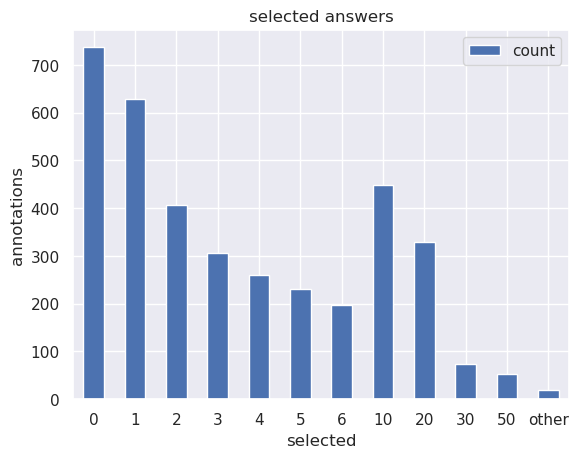

In [172]:
# Plot selection count
_, axis = plt.subplots()
plot_count_bins(axis, annotations_df.selected, [-1, 0, 1, 2, 3, 4, 5, 6, 10, 20, 30, 50, 1000], 'selected answers',
                'selected', 'annotations', digits=0)

Total annotators: 238
Total annotations: 3688
Mean annotations per annotator: 15.5
Median annotations per annotator: 6.0


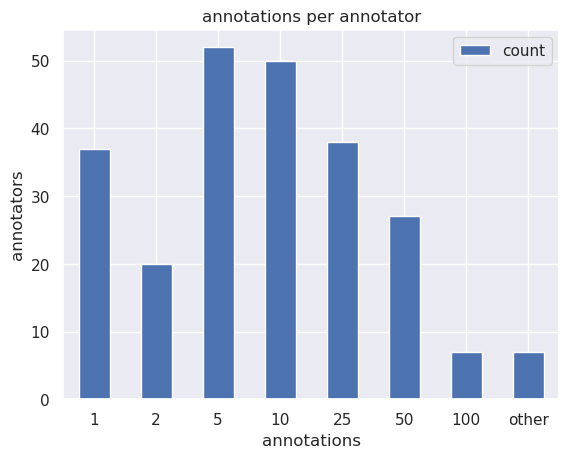

In [173]:
# Plot user contributions
group_by_user = annotations_df.user.value_counts().reset_index()
group_by_user.columns = ['user', 'annotations']
print('Total annotators:', len(group_by_user))
print('Total annotations:', len(annotations_df))

_, axis = plt.subplots()
plot_count_bins(axis, group_by_user.annotations, [0, 1, 2, 5, 10, 25, 50, 100, 1000], 'annotations per annotator',
                'annotations', 'annotators', digits=0)